# Creating Customer Segments

**Ronny Restrepo**

## Summary

Being able to categorize customers into meaningful groups (customer segmentation) based on spending habits is valuable for businesses. Doing so can give a business insight regarding how to best meet the specific needs of different groups of customers. It can also allow a business to perform A/B testing more effectively, by discovering how particular changes will affect different groups of customers differently.

This project made use of the Wholesale Customers Dataset from the UCI Machine Learning Repository which contains the annual spending habits of 440 clients of a whole sale distributor. The goal was to find the best way to describe the variation of diffrerent types of customers that a wholesale distributor interacts with. 


An unsupervised learning algorithm was used to create create meaningfully different groups of customers. Specifically, Principle Component Analysis was used for dimensionality reduction of the features down to just two. Reducing the number of features to just two was done in order to keep the analysis interpretable, and capable of being visualized. A clustering algorith (Gaussian Mixture Model) was then used for clustering the customers into separate groups. Different numbers of clusters were attempted, and evaluated using a Silhouette score. It was discovered that the best way to cluster the customers was to split them into two separate groups. This resulted in a Silhouette Score 0.429.

## The Data

The [Wholesale Customers Dataset](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)  from the UCI Machine Learning Repository contains the annual spending habits of 440 clients of a whole sale distributor, covering a diverse set of product categories. 

Since the purpose of this project is to discover if meaningful clusters can be discovered from only the spending habits of customers, two variables were removed from the original dataset. These included the `'Channel'` and `'Region'` features. What remains are six product categories.

## Loading the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from collections import Counter 

# Import plotting library 
import matplotlib.pyplot as plt

# Show plots inline (nicely formatted in the notebook)
%matplotlib inline

In [2]:
# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded.")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration

We can observe some basic statistical descripitons of the data such as the mean standard deviation, quartiles, etc.  Each column represents each of the six different product categories.

In [3]:
# Description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples to Track

A few data points are selected in order to maintain an intuition for how the data is being transformed through the analysis. Three samples were selected manually, specifically chosen to be very different from each other. 

In [4]:
# Indices of three selected samples from data
indices = [43,181, 122]

# DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,630,11095,23998,787,9529,72
1,112151,29627,18148,16745,4948,8550
2,12212,201,245,1991,25,860


In order to compare how the different clients differ more easily, the following table shows the product category purchases converted into z-scores, which tells us the purchasing habits in terms of how many standard deviations it is from the average client.

In [5]:
(samples - data.mean()) / data.std()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-0.899028,0.717949,1.688567,-0.470666,1.394234,-0.515183
1,7.918724,3.228932,1.072982,2.816475,0.433425,2.491087
2,0.016739,-0.758127,-0.810917,-0.222658,-0.599115,-0.235761


We can see that client 0 spent above average on Milk, Grocery, and Detergents, but little on perishables like fresh food and delicatessen. This would suggest that this client could potentially be a convenience store. 

Client 1 spent above average on all product categories, in many cases many standard deviations above average. This implies that it is a client with very large purchasing power, and large clientelle, and is therefore likely to be a supermarket that itself re-sells all of those items to the general public. 

Client 2 spent below average on all product categories except for fresh food (which was close to average). It's greatest expenditure was on Fresh food, Frozen food and delicatessen. This could potentially be the spending habits of a restaurant. 

### Feature Relevance

An interesting question to ask ourselves is: *can we predict how much a customer will spend annualy on a particular product category based on how much they spend on the other categories of items?*.

Answering this question will allow us to discover which variables are most relevant. It will also allow us to see which ones are redundant or can be explained in terms of the other variables. 

We can discover the answer to this by training six separate supervised regression models. For each of these models, we set aside a different feature to be used as a target labels to be predicted, and use the remaining features as the inputs of the model. Each model is then evaluated (on a subset set aside for testing) to see how well it can predict the target labels.  

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Seeing how well each feature in the dataset can be explained by the rest of 
# the data 
for target_feature_name in data.columns:
    # Create a new dataframe with one feature removed
    new_data = data.drop(target_feature_name, axis = 1)

    # Split the new data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data[target_feature_name], 
                                                    test_size=0.25, 
                                                    random_state=42)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(max_depth=5, random_state=23)
    regressor = regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("R^2 score when using '{}' "\
          "as the target: {}".format(target_feature_name, score))

R^2 score when using 'Fresh' as the target: -0.19565796675907654
R^2 score when using 'Milk' as the target: 0.4110453005339162
R^2 score when using 'Grocery' as the target: 0.7494868833592407
R^2 score when using 'Frozen' as the target: 0.06810539292275941
R^2 score when using 'Detergents_Paper' as the target: 0.4766868720269922
R^2 score when using 'Delicatessen' as the target: -0.9907653155153816


As can be seen from the above output, when we use `'Grocery'` as the variable to be predicted, we get an $R^2$ score of approximately 0.75. This indicates that 75% of its variability can be explained by the variability of the rest of the features. This indicates that it is the least important feature in our dataset. 

If we had to reduce the number of features in the dataset, then `'Grocery'` would be the first variable that we should consider removing. However, there is still 25% of its variability that is not explained by any of the other features, so it might be useful to keep it around in order to boost the performance of our model. 

If we contrast this with `'Delicatessen'`, we see that the regression model used to predict that feature using the remaining features does incredibly poorly. This suggests that `'Delicatessen'` is an important feature that we should definitely keep around. 

### Feature Distributions

To get a deeper understanding of how the variables in the dataset relate to each other, we can construct a scatter matrix of each of the six product features. 

What we should hopefully find is that the most relevant variables should be uncorrelated with any of the other variables. And since we identified that some `Groceries`, and `Detergents_paper` were the two least relevant variables, it should not be surprising if they are correlated with other variables. 

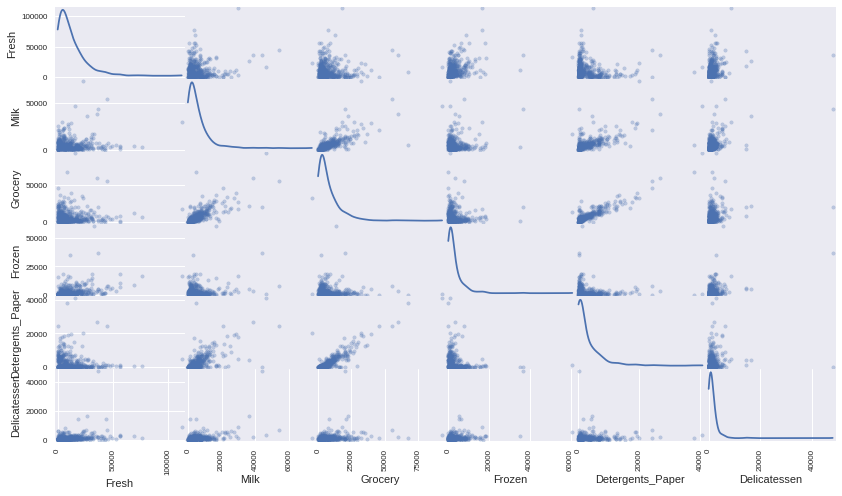

In [11]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

We can see that there appears to be a clear correlation between the two least relevant variables `Grocery` and `Detergents_Paper`. We can get a more precise understanding of this correlation by creating a correlations matrix heatmap. 

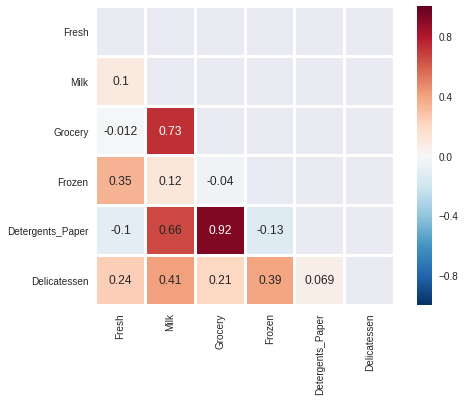

In [12]:
import seaborn as sns
mask = np.triu(np.ones((6,6)), k=0)
sns.heatmap(data.corr(), annot=True, square=True, mask=mask, linewidths=2)

We can see that there is a very strong linear correlation between the `'Grocery'` and the `'Detergents_Paper'` features. Previously, we saw that the Grocery feature could be predicted using the remaining variables with an $R^2$ score of aproximately 0.75, the scatterplot and correlations matrix heatmap show us that `'Detergents_Paper'` is the variable that contributes the most towards that prediction. 

To a lesser extent there is also a correlation between `'Milk'` and `'Grocery'` and also between  `'Milk'` and `'Detergents_Paper'`. This also coincides with the previous observation that the `'Milk'` and `'Detergents_Paper'` could be explained by the remaining variables with an $R^2$ score of greater than 0.4 and less than 0.5. 

We can also see from the scatte plots matrix that the features for this data are heavilly skewed. Most of the data points are within the lower region of values. It would therefore be beneficial to perform some transformation to normalize the data somewhat. 

### Feature Scaling

Financial data can often be heavily skewed, and it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling. We could achieve this through a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data to reduce skewness. Alternatively, a simpler approach, which can work in most cases is to simply apply the natural logarithm.

In [16]:
import matplotlib
matplotlib.style.use('ggplot')

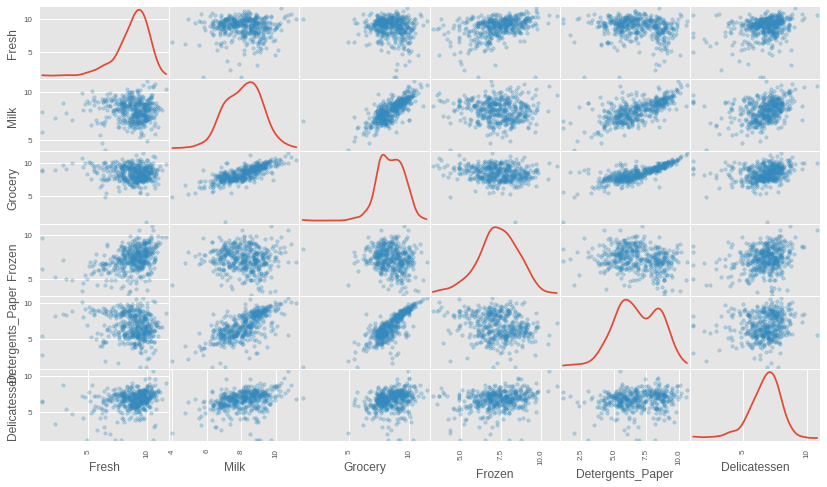

In [17]:
# Scale the data using the natural log
log_data = np.log(data)

# Scale the three selected clients data in the same way
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

After scaling the data using the natural logarithm, we see that the distribution of each feature is much more normalized. We can also see that the features that appeared to be correlated still remain correlated after transformation. We can get a more precise calculation of those correlations by again running a correlation matrix heatmap on the transformed data. 

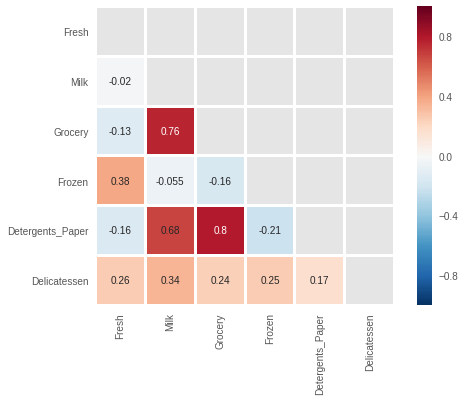

In [18]:
mask = np.triu(np.ones((6,6)), k=0)
sns.heatmap(log_data.corr(), annot=True, square=True, mask=mask, linewidths=2)

Although the specific values of the correlations have changed, we see that the same ones still remain high. 

## Outlier Detection

In order to detect the presence of outliers which could skew the results of analysis, [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/) will be used. Namely, an outlier will be defined as any data point that lies beyond 1.5 times the interquartile range (IQR) for a given variable.

In [19]:
# For each feature find the data points with extreme high or low values
outliers_tally = Counter()
for feature in log_data.keys():
    
    # Calculate Q1, and Q3 (25th, and 75th percentiles) for the given feature
    Q1 = log_data[feature].quantile(0.25)
    Q3 = log_data[feature].quantile(0.75)
    
    # Use the IQR to calculate an outlier boundary
    step = 1.5 * (Q3 - Q1)
    
    # Get the outliers for this feature
    new_outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    
    # Add these outlier indices to the set of all outlier indices
    outliers_tally.update(new_outliers.index)

# Separate the outliers
outlier_indices = outliers_tally.keys()
outliers_df = log_data.loc[outlier_indices]

# Show the outliers
display(outliers_df) 

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612


In [20]:
print("Number of data points considered outliers: {}".format(len(outlier_indices)))

Number of data points considered outliers: 42


We can see that there is quite a lot of samples that are considered outliers for at least one feature. 

It might not be a good idea to eliminate all 42 outliers for a dataset with only 440 data points in total. Removing all these points could negatively affect a model we create from it. So instead we will need to pick out a subset of the outliers. We will concentrate on only those data points that are outliers for more than one feature at once. 

In [21]:
# Row indices that are marked as outliers for more than one feature
dup_outliers = [index for index, count in outliers_tally.items() if count > 1]

print("Data Points Considered Outliers for more than one feature")
print(dup_outliers)

Data Points Considered Outliers for more than one feature
[128, 65, 66, 75, 154]


This gives us a much smaller set of data points, and we could potentially look at whether these indeed pick out the worst offending data points by visualising those points. These points will be plotted as red dots in the following plot, the remaining outliers will be green, and the non-outlier points will be small grey dots. 

In [22]:
def format_point_aesthetics(data, outlier_indices=[], removal_indices=[]):
    """
    data:             The full data 
    outlier_indices:  List of indices of all the points considered outliers
    removal_indices:  List of indices of the points to consider removing
    
    Returns:          A dictionary containing the "size" and "color" for each 
                      data point. It assigns larger red values for for data 
                      points to be removed, medium sized green for the outliers 
                      that are not to be removed, and all others are assigned 
                      to be small and grey.
    """
    colors = ["#FF0000" if index in  removal_indices     # red for removals
              else "#00FF00" if index in outlier_indices # green for outliers 
              else "#AAAAAA" for index in data.index]    # grey for all others
    
    sizes = [50 if index in  removal_indices       # biggest for removals
             else 30 if index in outlier_indices   # medium for outliers
             else 5 for index in data.index]       # small for all others
    
    return {"color": colors, "size": sizes}
    

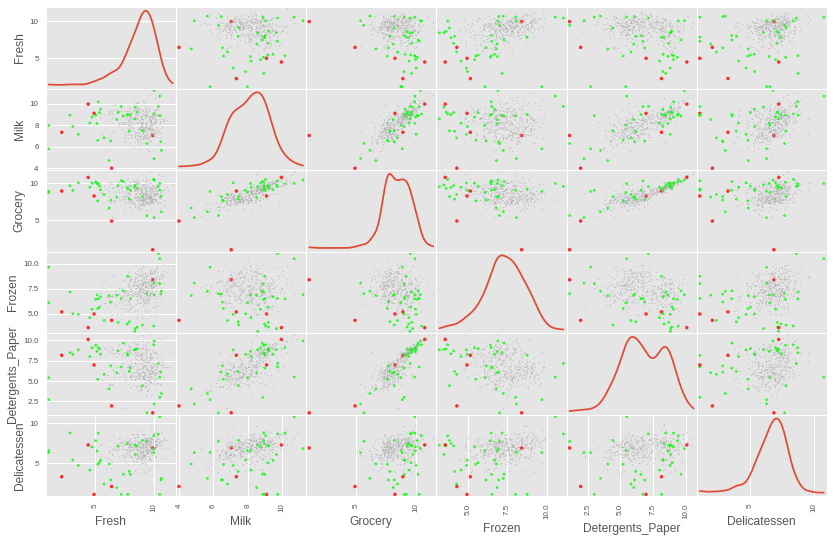

In [23]:
# Plot the data, highlighting outliers and potential points to remove
point_aes = format_point_aesthetics(log_data, outlier_indices, dup_outliers)
img = pd.scatter_matrix(log_data, alpha = 0.8, figsize=(14, 9), diagonal='kde', 
                        marker=".", c=point_aes["color"], s = point_aes["size"], 
                        linewidths=0)

We can see that some of those points that are considered outliers for more than one feature are indeed some of the worst offending points that really seem to lie way outside the rest of the data. 

However, when each one of these candidate outliers are visualised separately (not shown here to avoid having too many plots), it is not entirely clear that points 65 and 66 should be removed. They do not stand out as sticking out too much from the rest of the points for any of the cells in the plot, so they will not be removed from the data.  This leaves us with points 128, 154 and 75 as candidates to remove.

In [24]:
removals = [128, 154, 75]

It is also clear that there are other extreme outliers. So these will be chose manually. The following are some aditional data points that will be flagged for removal, the indices were extracted by looking up the outliers dataframe printed out above. 

- There are some extreme points with a `'Fresh'` value of less than 2
- There are some extreme points with a `'Delicatessen'` value of approximately less than 2
- There is an aditional extreme point with a `'Detergents_Paper'` value of approximately 1

In [25]:
# Include more hand selected outliers for removal
removals.extend([95, 338,             # Fresh < 2
                 142, 187, 109,       # Delicatessen ~< 2
                 161,                 # Detergent ~ 1
                ])

With those values selected, we can visualise the points chosen for removal in the plot below. It may appear if some of the points are not outliers at all since they appear to be right in the center of some of the cells below. However, those data points that appear in the center of some of the cells, actually appear as extreme outliers in some of the other cells. 

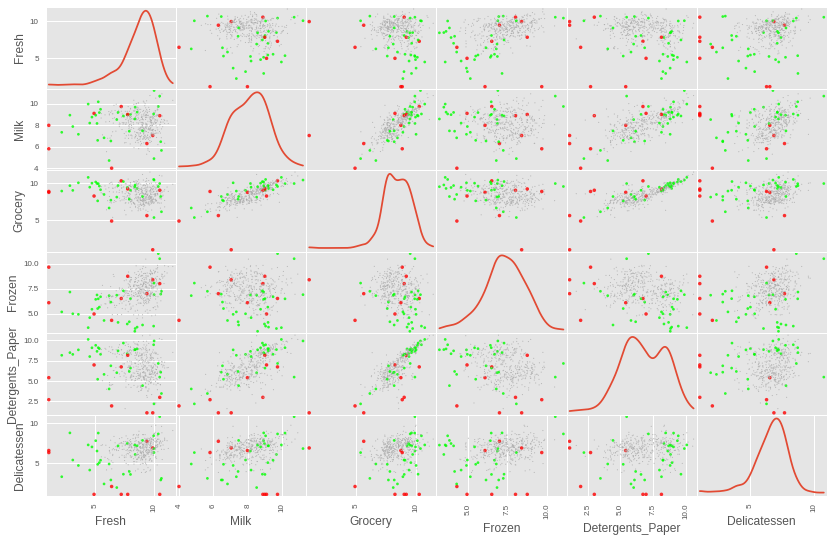

In [26]:
# Plot the data, highlighting outliers and manually selected points to remove
point_aes = format_point_aesthetics(log_data, outlier_indices, removals)
img = pd.scatter_matrix(log_data, alpha = 0.8, figsize=(14, 9), diagonal='kde', 
                        marker=".", c=point_aes["color"], s = point_aes["size"], 
                        linewidths=0)

We can now remove those datapoints and create a clean data set to be used for the rest of the project.

In [27]:
# Remove the worst offending outliers
good_data = log_data.drop(log_data.index[removals]).reset_index(drop = True)

And as a precaution, we can check if any of three datapoints selected at the begining of the project to track are amongst the outliers that we just removed. 

In [28]:
# Check if any of the sample data points chosen previously have been diagnosed 
# as outliers to be removed from the dataset
overlap = [index for index in indices if index in removals ]
if len(overlap) > 0:
    print("The following sample indices "\
          "chosen earlier are outliers: {}".format(overlap))
else: 
    print("Safe! None of the sample indices chosen earlier are outliers")

Safe! None of the sample indices chosen earlier are outliers


We can finally print out another plot to view just the good data points. We can see that the data is looking much nicer now, with the extreme points removed. 

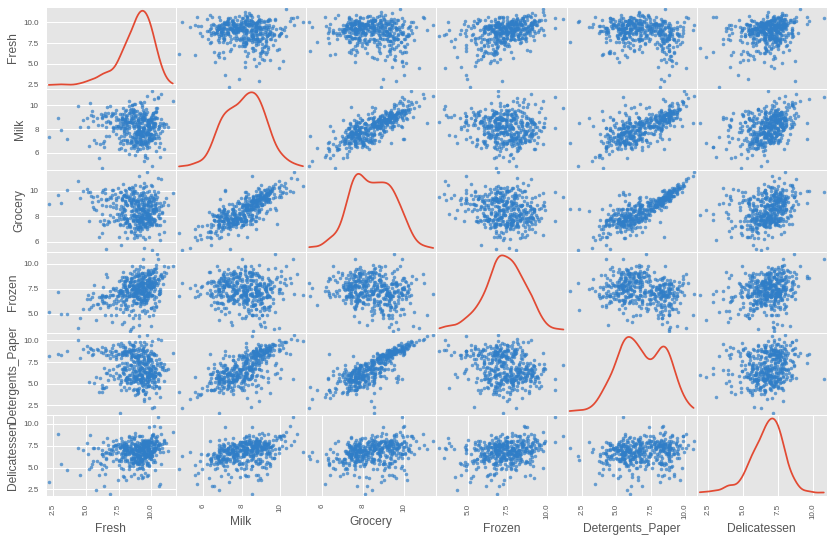

In [29]:
# Plot the good data with worst offending outliers removed
img = pd.scatter_matrix(good_data, alpha = 0.7, figsize=(14, 9), diagonal='kde', 
                        marker=".", c="#307EC7", s = 50, 
                        linewidths=0)

## Dimensionality Reduction

In order to make the clustering more interpretable, and easy to visualize, we can perform a transformation on the data to reduce the most important information to just two dimensions. We will use Principal Component Analysis (PCA) to do this. PCA will essentially transform the data into a new coordinate system. The dimensions of this new coordinate system are ordered in terms of how much variance they are capable of explaining. This allows us to select the first dimensions, which will contain the most predictive power. PCA will also report the *explained variance ratio* of each dimension — that is, how much variance within the data is explained by that dimension alone. 

In [30]:
from sklearn.decomposition import PCA

# Apply PCA to the good data with the same number of dimensions as features
pca = PCA()
pca.fit_transform(good_data)

# Apply the same PCA transformation to the three samples data points
pca_samples = pca.transform(log_samples)

In [31]:
# The variance explained by each principal component
explained_variances = pca.explained_variance_ratio_ 

print("Proportion of the variance explained by each dimension")
print("\n".join(["{}: {:1.3f}".format(i+1,val) for i,val in enumerate(explained_variances)]))

# Total Variance explained by the nth principal components
cumulative_variance = [explained_variances[:i+1].sum() for i in range(len(explained_variances))]
print("\nTotal variance explained by the first N principal compoments")
print("\n".join(["{}: {:1.3f}".format(i+1,val) for i,val in enumerate(cumulative_variance)]))

Proportion of the variance explained by each dimension
1: 0.459
2: 0.274
3: 0.108
4: 0.096
5: 0.043
6: 0.020

Total variance explained by the first N principal compoments
1: 0.459
2: 0.733
3: 0.841
4: 0.937
5: 0.980
6: 1.000


We can see that 73.3% of the variance is explained by the first two principal components combined, and 93.7% is explained by the first four principal components.

We can apply the PCA transormation on the data, preserving only the first two principal components.

In [32]:
# Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the three sample points
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Clustering

Now that the data has been cleaned up, and rediced to the two most important variables, we can perform clustering. 

Two possible clustering algoriths to use are:

- K-means clustering
- Gaussian Mixture Model (GMM)

The K-means algorithm uses hard assignment, classifying points definitively into one or another cluster. GMM on the other hand allows for there to be fuzziness between clusters, where some data points might lie somewhere in between either cluster, but not definitively clear which one it might belong to. If we take a look at our reduced data, we might be able to decide which of those two algorithms is the most appropriate. 

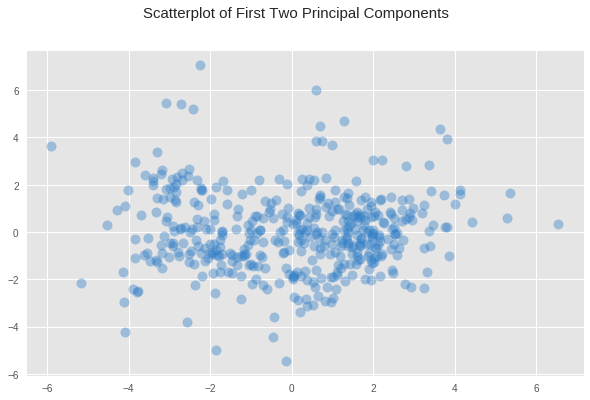

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Scatterplot of First Two Principal Components', fontsize=15)
img = ax.scatter(reduced_data["Dimension 1"], reduced_data["Dimension 2"], 
                 c="#307EC7", s=100, alpha=0.4, linewidths=0)

What we see from the plot above is a bigger concentration of data points just to the left of center, and another smaller concentration just right of the center. But the boundary between them is not entirely clear, there is no clear gap of no values that marks such a boundary, only a slight decrease in the concentration of points between these two regions. Given this fuzziness in the boundaries, where a data point could belong to one category or another, it seems that GMM might be the better option. 

One downside to GMM is that it does [not scale](http://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) particularly well, so it is only useful for small datasets. Fortunately, this is a fairly small dataset, and the algorithm should run within a reasonable amount of time. 

##  Creating Clusters

We do not know ahead of time how many clusters we need to group the customers into. As such, there will need to be a certain amount of exploration to see what the best number of clusters is. We can therefore try multiple number of clusters, and evaluate how good that number of clusters is using the *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster. It is a value ranging from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides us with a metric to evaluate different clusterings.

In [34]:
# Import GMM and silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Different values for number of clusters to use (from 2 to 11)
num_clusters_list = range(2, 11+1) 
num_cluster_values = len(num_clusters_list)

# Initialize lists to store predictions, centroids, and evaluation scores
preds_list = [[]] * num_cluster_values         # Predictions
sample_preds_list = [[]] * num_cluster_values  # Predictions for sample data
centers_list = [0] * num_cluster_values        # Centers
score_list = [0] * num_cluster_values          # scores

# For each value of clusters to consider, perform clustering and make 
# predictions, store the centers, and calculate the score
for i, num_clusters  in enumerate(num_clusters_list):
    # Apply the clustering algorithm to the reduced data 
    clusterer = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=4)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds_list[i] = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers_list[i] = clusterer.means_ 

    # Predict the cluster for each transformed sample data point
    sample_preds_list[i] = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score_list[i] = silhouette_score(reduced_data, preds_list[i], 
                                     metric='euclidean', sample_size=None, 
                                     random_state=4)

We can now extract which of those models gave the best results.

In [36]:
import operator

# Get k value that resulted in the best clustering model
best_k_index = max(enumerate(score_list), key=operator.itemgetter(1))[0]
k = num_clusters_list[best_k_index]

# Get the predictions, centers, and score for the best clustering model
preds = preds_list[best_k_index]
centers = centers_list[best_k_index]
score = score_list[best_k_index]

print("The best score was achieved with k={} (score={:0.3f})".format(k, score))

The best score was achieved with k=2 (score=0.429)


From the above print out we can see that the best silhouette score was 0.429, which was achieved when we used 2 clusters. We can visualize how this model compared with other models using different number of clusters in the grid of scatter plots below. We can see that the silhouette score, for the *most* part, got worse with an increased number of clusters.  

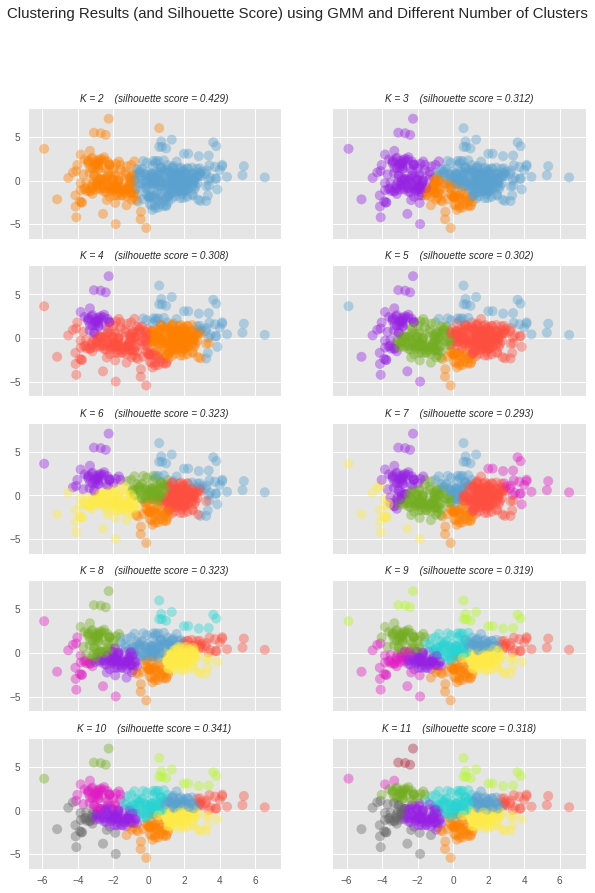

In [37]:
# Color Pallete for clustered points
PALLETTE =  ["#FF8000", "#5BA1CF", "#9621E2", "#FF4F40", "#73AD21",
            "#FFEC48", "#DE1BC2", "#29D3D1", "#B4F924", "#666666", "#AF2436"]

# For each of the number of clusters values considered, create a subplot
f, axes = plt.subplots(int(np.ceil(len(num_clusters_list) / 2.0)), 2, 
                       figsize=(10, 14), sharex=True, sharey=True)
axes = [item for row in axes for item in row] # Unroll axes to a flat list

for i in range(len(num_clusters_list)):
    # Plot data points, assigning a different color based on cluster assignment
    ax = axes[i]
    colors  = [PALLETTE[y] for y in preds_list[i]]    
    ax.scatter(reduced_data["Dimension 1"], 
               reduced_data["Dimension 2"], 
               c=colors, s=100, alpha=0.4, linewidths=0)
    
    # Set the title for the subplot including number of clusters used and 
    # the silhouette score.
    ax.set_title(
        "K = {k}    (silhouette score = {score:.3f})"\
        "".format(k=num_clusters_list[i], score=score_list[i]), 
        fontdict= {"style": "italic", "size": 10})

# Set the title for the figure
t = f.suptitle('Clustering Results (and Silhouette Score) using GMM and Different Number of Clusters',
               fontsize=15, 
               fontdict={"fontweight": "extra bold"})

We can view a larger version of the best clustering, along with where the three samples (as black circles) that were chosen earlier fall into the clusters. The centroids for each cluster have also been included. These represent the theoretical average customer for each cluster.  

In [145]:
def cluster_viz(reduced_data, labels, centers=None, reduced_samples=None, title="", legend_labels=["Segment 1","Segment 2"]):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions. 
    Optionally also show the centroids for each cluster, and the sample data 
    points
    '''
    f, ax = plt.subplots(1, 1,  figsize=(12, 10))

    PALLETTE =  ["#FF8000", "#5BA1CF"]
    colors  = [PALLETTE[y] for y in labels]    
    
    classes = np.unique(labels)
    for class_id in classes:
        ax.scatter(reduced_data["Dimension 1"][labels==class_id], 
                   reduced_data["Dimension 2"][labels==class_id],
                   label=legend_labels[class_id],
                   c=PALLETTE[class_id], s=100, alpha=0.4, linewidths=0)

#     ax.scatter(reduced_data["Dimension 1"][labels==class_id], 
#        reduced_data["Dimension 2"][labels==class_id],
#        c=colors, s=100, alpha=0.4, linewidths=0)


    # Plot centeroids
    if centers is not None:
        for i, c in enumerate(centers):
            ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors=PALLETTE[i], \
                       alpha=1, linewidth=2, marker = 'o', s=300);
            ax.scatter(x = c[0], y = c[1], marker='${}$'.format(i), alpha=1, s=100);

    # Plot transformed sample points 
    if reduced_samples is not None:
        ax.scatter(x = reduced_samples[:,0], y = reduced_samples[:,1], \
                   s = 300, 
                   linewidth = 2, 
                   color = 'black', 
                   facecolors = 'none',
                   edgecolors='black',
                   marker = 'o');

        for i in range(len(reduced_samples)):
            ax.scatter(x = reduced_samples[i,0]+0.4, y = reduced_samples[i,1], marker='$({})$'.format(i), alpha = 1, color='black', s=350);

    ax.legend(loc="lower right", frameon=False)

    # Set plot title
    ax.set_title(title);

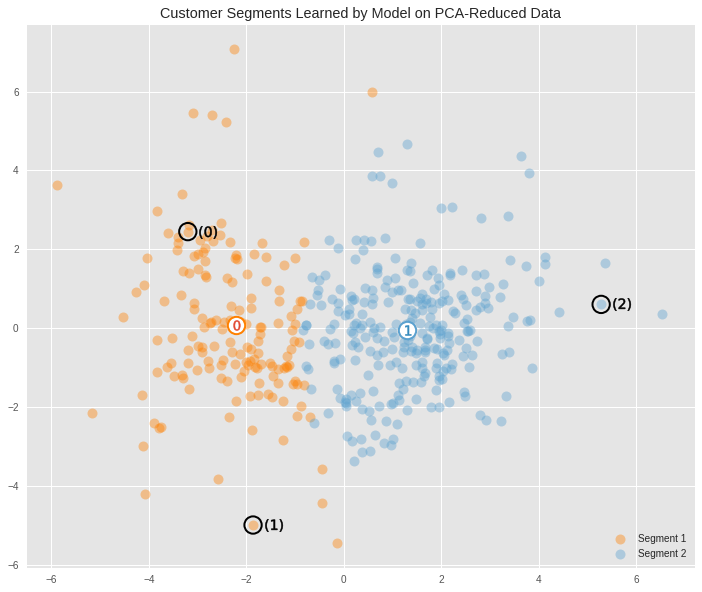

In [146]:
cluster_viz(reduced_data, 
            labels=preds, 
            centers=centers, 
            reduced_samples=pca_samples, 
            title="Customer Segments Learned by Model on PCA-Reduced Data")

## The average customers for each cluster

We can perform data recovery steps to find out what the representative customer spending habits for each cluster would look like on the original data. We can do so by reversing each of the transformations that were performed on the original data, in reverse order.

In [147]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers (inverse of log transformation)
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3807.0,8041.0,12398.0,902.0,4745.0,1075.0
Segment 1,8876.0,2053.0,2691.0,2002.0,359.0,717.0


The above table shows what the spending habits of the average customer for each cluster looks like. But to get a better idea of how their relative spending habits differ, we can convert the raw spending units into z-scores, which will show the amount of deviation from the mean. 

In [56]:
(true_centers - data.mean()) / data.std()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-0.647828,0.304149,0.467920,-0.446978,0.390848,-0.159523
Segment 1,-0.247032,-0.507192,-0.553529,-0.220392,-0.529063,-0.286468


**Segment 0** spends at an above average rate on items like milk, gorcery and detergents, indicating that it might represent gorocery stores. 

**Segment 1** spends on all product categories at below average, but the highest items are fresh food, frozen food, and delicatessen. These are all food based products, indicating that this segmentation might represent clients that are restaurants.

We can use the clustering model to make predictions about what segmentation the three sample points chosen at the begining of this project fall into. 

In [101]:
sample_preds = sample_preds_list[best_k_index]

# Print out the predictions
potential_cust_segments = ["grocery", "restaurant"]
for i, pred in enumerate(sample_preds):
    print("Client {} predicted to be in Segment {} ({})".format(i, pred, 
                                                 potential_cust_segments[pred]))

Client 0 predicted to be in Segment 0 (grocery)
Client 1 predicted to be in Segment 0 (grocery)
Client 2 predicted to be in Segment 1 (restaurant)


The results of this clustering seem somewhat consistent with the initial intuitive predictions made at the begining of this report. Since we have clustered things into just two groups, then some of the possible types of businesses have been squashed into other ones that are similar. The original prediction was that `client 0` and `client 1` were a convenience store and a supermarket respectively. These are very similar kinds of businesses in terms of the types of things they would buy, so it is not surprising that the two clients were collaped into the same cluster, and that the center point of this cluster shows the spending habits of a potential supermarket type of businesses. 

The clustering algorithm also predicted that `client 2` belonged to a different group than the other two points. This is also consistent with the initial manual prediction made earlier. And the spending habits of the center point for this cluster also seems consistent with `client 2`, and points to a potential spending habits of a restaurant. 

## The Real-Underlying Distribution

The purpose of this report was to find if we could meaningfully segment the clients of a business based exclusively on the annual spending habits. We removed any features from the data that did not have anything to do with the spending habbits. However, the original data actually contained a feature called `Channel` which does contain information about the type of business the clients are. 

According to the [documentation](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) for the dataset, the `Channel` labels represent `Hotel/Restaurant/Cafe` and `Retail` businesses. 

We can visualize that distribution in the plot below. 

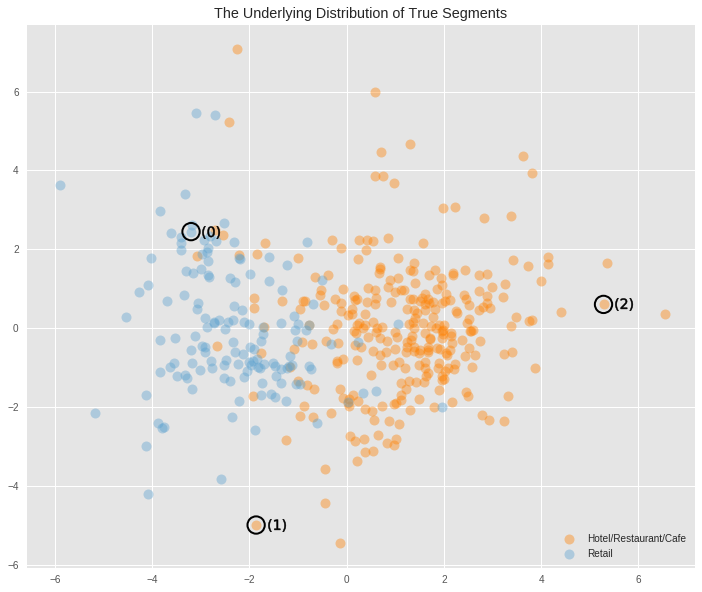

In [148]:
# Load the full data 
try:
    full_data = pd.read_csv("customers.csv")
except:
    print("Dataset could not be loaded.")


# Create the Channel DataFrame (removing the same outlier data points)
channel = full_data['Channel']-1
channel = channel.drop(channel.index[removals]).reset_index(drop = True)

# Plot the distribution
cluster_viz(reduced_data, 
            labels=channel, 
            reduced_samples=pca_samples, 
            title="The Underlying Distribution of True Segments", 
            legend_labels=["Hotel/Restaurant/Cafe", "Retail"]
            )

The underlying distribution had split the data into two categories. When visualised in two dimensions we can see that the region above aproximately 2 in `Dimension 1` is a region that is purely populated by *Hotels/Restaurants/Cafes*. Aproximately below -3.5 in the same dimension is the region populated purely by Retailers. The region in between contains a fair bit of overlap between these two categories, but it is clear that the region above -0.5 in `Dimension 1` is populated predominantly by *Hotels/Restaurants/Cafes*, and values below that are predominantly populated by *Retailers*. 

The clustering algorithm comes quite close to splitting the data into these two categories correctly, but given the amount of overlap that exists in the data it is reasonable to expect some amount of error. 

The clustering algorithm correctly clustered two of the sample data points to different groups, but for point 1, it incorrectly labelled it as belonging to the *Retailers* cluster when in fact it belonged to the *Hotels/Restaurants/Cafes* cluster. But this was a dificult data point to classify correctly anyway as it lay within that region of overlap.

We can evaluate how much similarity there is between the segments of the underlying distribution, and the segmentation created by the model as follows. Note, that the labels on the predictions are flipped (`1-preds`) because the labels created by the model for the different clusters is the opposite of the convention used in the labels from the raw data. 

In [156]:
acc = ((1-preds) == np.asarray(channel)).mean()
print("Accuracy = {:2.3f}%".format(acc*100))

Accuracy = 89.095%


We can see that the predictions from the trained model coincide with 89% of the labels from the underlying distribution. 

## Conclusion

The project set out to investigate whether clients of a business could be segmented into meaningful groups based exclusively on the spendng habits. What was discovered was the spending habits of clients can indeed be used to make such discoveries, and that it does so quite well. When compared to the ground truth clusters, we saw that an unsupervised learning algorithm came up with a similar clustering of the clients into separate groups, and also the same number of groups.    

Being able to segment clients into different groups is of great value to a business wanting to conduct A/B testing when making small changes to its products or services. 

This is because these changes might not affect all kinds of clients equally, there are some that might be more negatively affected than others. A good way to test whether such changes should be made, and whether they should only be made to some customers is to make use of the groups that the data is assigned to using the clustering algorithm. By performing A/B testing on subsets of clients from each of the groups, you can find out if the changes affects any or all of those separate groups, and allows you to make those changes to only the groups that had positive (or no negative) effects

Being able to cluster clients into different segments could also be used as a preprocessing step for a supervised learning algorith when making predictions of clients. This could be done by making use of the predicted cluster of a client as another input feature for the supervised learning algorithm.  